In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=0258f1184faf07573e47467467e9eecbe57ef8c1eb8edfc0466d6a553e714326
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import numpy as np


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Spark Session

In [6]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('clustering').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.4.0


## K-mean Clustring

In [9]:

#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

## Read Data

In [14]:
dataset = spark.read.csv("/content/drive/MyDrive/BD_Dataset/Google-Playstore.csv",header=True,inferSchema=True)
dataset.show(5)


+--------------------+--------------------+-------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+------------+------------+--------------+--------------------+------------+----------------+--------------+-------------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Installs|Minimum Installs|Maximum Installs|Free|Price|Currency|Size|Minimum Android|        Developer Id|   Developer Website|     Developer Email|    Released|Last Updated|Content Rating|      Privacy Policy|Ad Supported|In App Purchases|Editors Choice|       Scraped Time|
+--------------------+--------------------+-------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+------------+------------+--------------+--------------------+----------

## Data Schema

In [16]:
dataset.printSchema()


root
 |-- App Name: string (nullable = true)
 |-- App Id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rating Count: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Minimum Installs: string (nullable = true)
 |-- Maximum Installs: string (nullable = true)
 |-- Free: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Minimum Android: string (nullable = true)
 |-- Developer Id: string (nullable = true)
 |-- Developer Website: string (nullable = true)
 |-- Developer Email: string (nullable = true)
 |-- Released: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Privacy Policy: string (nullable = true)
 |-- Ad Supported: string (nullable = true)
 |-- In App Purchases: string (nullable = true)
 |-- Editors Choice: string (nullable = true)
 |-- Scra

In [17]:
ratings = dataset.select('Rating')

## Drop Null values

In [18]:
ratings = ratings.dropna()

### Cast string to float

In [21]:
from pyspark.sql.types import DoubleType
ratings = ratings.withColumn('Rating',ratings['Rating'].cast(DoubleType()))

In [22]:
# from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
  
vec_assembler = VectorAssembler(inputCols =ratings.columns,
                                outputCol='Transformed_Rating', handleInvalid="skip")
  
final_data = vec_assembler.transform(ratings)
final_data.select('Transformed_Rating').show(5)

+------------------+
|Transformed_Rating|
+------------------+
|             [0.0]|
|             [4.4]|
|             [0.0]|
|             [5.0]|
|             [0.0]|
+------------------+
only showing top 5 rows



In [23]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="Transformed_Rating",
						outputCol="scaledFeatures",
						withStd=True,
						withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

final_data.select('scaledFeatures').show(5)


+--------------------+
|      scaledFeatures|
+--------------------+
|               [0.0]|
| [2.089050144797001]|
|               [0.0]|
|[2.3739206190875004]|
|               [0.0]|
+--------------------+
only showing top 5 rows



## Compute score 

In [30]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
  
silhouette_score=[]
  
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')
  
for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    model=kmeans.fit(final_data)
    predictions=model.transform(final_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.9602706153397479
Silhouette Score for k = 3 is 0.8576528097053818
Silhouette Score for k = 4 is 0.8419256666689326
Silhouette Score for k = 5 is 0.8424170375240393
Silhouette Score for k = 6 is 0.8354317641624895
Silhouette Score for k = 7 is 0.842643554836007
Silhouette Score for k = 8 is 0.8437845487934451
Silhouette Score for k = 9 is 0.8468475402899964


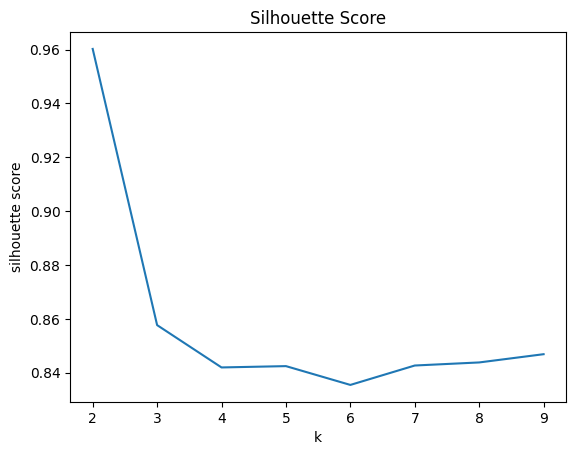

In [31]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
  
plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [24]:

# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

In [27]:
print(type(kmeans))

<class 'pyspark.ml.clustering.KMeans'>


In [32]:
# Printing cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.33544472]
[0.]
[1.32769343]
[1.81809598]
[2.02109851]
[2.18082764]
[1.5824386]
[0.7391024]
[1.04178062]


In [ ]:

#End Session
spark.stop()